## Helpers

In [1]:
# helpers
import numpy as np
import itertools
import os
import time
import matplotlib.pyplot as plt


def StateToArray(myState):

    m = len(myState)  # Number of states
    n = 2  # Number of columns in the state matrix
    state_mat = np.zeros((m, n), dtype=object)

    # Convert the list of state tuples to a numpy array
    for i in range(m):
        state_mat[i] = np.array([complex(myState[i][0]), myState[i][1]], dtype=object)

    return state_mat


def PrettyPrintBinary(myState, round=True):

    state_mat = StateToArray(myState)
    m, n = state_mat.shape

    # Sort the state matrix by the binary representation
    sort_indices = np.argsort(state_mat[:, 1])

    output = ""
    nchars = 0
    for i, index in enumerate(sort_indices):

        coeff = state_mat[index][0]
        binary = state_mat[index][1]

        if i != m - 1:
            if round:
                toAdd = str(np.round(coeff, 4)) + "|" + str(binary) + "> + "
            else:
                toAdd = str(coeff) + "|" + binary + "> + "

        else:
            if round:
                toAdd = str(np.round(coeff, 4)) + "|" + binary + ">"
            else:
                toAdd = str(coeff) + "|" + binary + ">"
        nchars += len(toAdd)
        if nchars > 80:
            output += "\n"
            nchars = 0
        output += toAdd

    print(output)


def BinaryToDecimal(binary):

    if type(binary) == str:

        decimal = int(binary, 2)

    elif type(binary) == np.ndarray or type(binary) == list:

        decimal = np.zeros(len(binary), dtype=int)
        for i in range(len(binary)):
            decimal[i] = int(binary[i], 2)

    return decimal


def PrettyPrintInteger(myState, round=True):

    state_mat = StateToArray(myState)
    m, n = state_mat.shape

    state_mat[:, 1] = [BinaryToDecimal(state_mat[i][1]) for i in range(m)]

    sort_indices = np.argsort(state_mat[:, 1])
    output = ""
    nchars = 0
    for i, index in enumerate(sort_indices):

        coeff = state_mat[index][0]
        integer = str(state_mat[index][1])

        if i != m - 1:
            if round:
                toAdd = str(np.round(coeff, 4)) + "|" + integer + "> + "
            else:
                toAdd = str(coeff) + "|" + integer + "> + "

        else:
            if round:
                toAdd = str(np.round(coeff, 4)) + "|" + integer + ">"
            else:
                toAdd = str(coeff) + "|" + integer + ">"

        nchars += len(toAdd)
        if nchars > 80:
            output += "\n"
            nchars = 0
        output += toAdd

    print(output)


# get all binary numbers of n bits
def getBinaryList(nbits):

    binaryList = []
    for i in range(2**nbits):
        binaryList.append(format(i, "0" + str(nbits) + "b"))

    return binaryList


# turn Dirac notation into a vector
# the position in the corresponds to the in order binary number
def DiracToVec(myState):

    m = len(myState)  # Number of states
    n = 2  # Number of columns in the state matrix
    state_mat = np.zeros((m, n), dtype=object)
    nbits = len(myState[0][1])
    binaryList = getBinaryList(nbits)
    # Convert the list of state tuples to a numpy array
    for i in range(m):
        state_mat[i] = np.array([complex(myState[i][0]), myState[i][1]], dtype=object)

    # Add any missing states to the state matrix
    for num in binaryList:
        if num not in state_mat[:, 1]:
            state_mat = np.append(state_mat, np.array([[0, num]], dtype=object), axis=0)

    # Sort the state matrix by the binary representation
    sort_indices = np.argsort(state_mat[:, 1])
    vec = state_mat[
        sort_indices, 0
    ]  # Extract the state coefficients from the sorted state matrix

    return vec


def VecToDirac(myVec):

    n = len(myVec)
    nbits = int(np.log2(n))
    binaryList = getBinaryList(nbits)
    stateList = []

    for i in range(n):
        stateList.append((complex(myVec[i]), binaryList[i]))

    stateList = AddDuplicates(stateList)

    return stateList


def testProb(myState):

    if type(myState) == np.ndarray and myState.ndim == 1:

        assert np.isclose(np.sum(np.abs(myState) ** 2), 1.0)

    else:

        assert np.isclose(np.sum(np.abs(StateToArray(myState)[:, 0]) ** 2), 1.0)


def getDecimalList(nqubits):

    return BinaryToDecimal(getBinaryList(nqubits))


def AddDuplicates(myState):
    state_array = StateToArray(myState)
    coeffs = np.array(state_array[:, 0], dtype=complex)

    # Remove zero coefficients
    zero = np.isclose(coeffs, 0.0)
    state_array = state_array[~zero]

    # sum coefficients of identical states
    state_dict = {}
    for coeff, binary in state_array:
        if binary in state_dict:
            state_dict[binary] += coeff
        else:
            state_dict[binary] = coeff

    new_state = [
        (complex(coeff), binary)
        for binary, coeff in state_dict.items()
        if not np.isclose(coeff, 0.0)
    ]

    return new_state


def ReadInputString(myInput_lines):
    """Reads a quantum circuit from a string or file

    Parameters
    ----------
    myInput_lines : str or file path
        The input string or file path

    Returns
    -------
    tuple
        The number of wires and the quantum circuit as a list of lists
    """

    if os.path.isfile(myInput_lines):
        with open(myInput_lines, "r") as file:
            myInput_lines = file.read()

    myInput = []
    myInput_lines = myInput_lines.split("\n")
    myInput_lines = [i.strip() for i in myInput_lines if i.strip() != ""]
    numberOfWires = int(myInput_lines[0])
    for idx, line in enumerate(myInput_lines[1:]):

        toAdd = line.split()

        if idx == 0 and "INITSTATE" in toAdd:
            try:

                inputState = " ".join(toAdd[2:])
                eval(inputState)
                toAdd = toAdd[:2] + [inputState]

            except:

                pass

        myInput.append(toAdd)

    return (numberOfWires, myInput)


def readState(path):
    """Reads a state from a file or dirac string or dirac list of tuples

    Parameters
    ----------
    path : str, dirac notation (|101>), or list of tuples

    Returns
    -------
    np.ndarray
        The state in vector form
    """

    if not os.path.isfile(path):

        try:

            state = DiracToVec(eval(path))

        except:

            basis = path.split("|")[1].split(">")[0]
            state = [(1.0 + 0j, basis)]
            state = DiracToVec(state)

        return state.astype(complex)

    with open(path, "r") as file:
        myInput_lines = file.read()

    myInput_lines = myInput_lines.split("\n")
    myInput_lines = [line for line in myInput_lines if line != ""]

    state = []
    for line in myInput_lines:
        real = float(line.split()[0])
        imag = float(line.split()[1])

        state.append((complex(real, imag)))

    return np.array(state, dtype=complex)


def tensorProd(matrixList):
    """Compute the tensor product of a list of matrices

    Parameters
    ----------
    matrixList : list
        A list of matrices

    Returns
    -------
    np.ndarray
        The tensor product of the matrices
    """

    loop_matrix = matrixList[0]

    for matrix in matrixList[1:]:
        loop_matrix = np.kron(loop_matrix, matrix)

    return loop_matrix


def measureState(inputState, ntrials):

    nbits = len(inputState)
    empirical_probs = np.zeros(nbits)
    theoretical_probs = np.abs(inputState) ** 2
    theoretical_probs = theoretical_probs.astype(float)
    for i in range(ntrials):

        trial_measurement = np.random.choice(range(nbits), p=theoretical_probs)
        empirical_probs[trial_measurement] += 1

    empirical_probs /= ntrials

    return empirical_probs


def generateRandomCircuit(nbits, depth):
    """Generates a random quantum circuit by applying one atomic gate to each qubit at each depth

    Parameters
    ----------
    nbits : int
        The number of qubits
    depth : int
        The depth of the circuit

    Returns
    -------
    str
        The circuit
    """

    circuit = f"{nbits}\n"
    for _ in range(depth):
        for i in range(nbits):
            gate = np.random.choice(["H", "Phase", "CNOT"])
            if gate == "CNOT":
                control = i
                target = np.random.choice([j for j in range(nbits) if j != control])
                circuit += f"{gate} {control} {target}\n"
            else:
                circuit += f"{gate} {i}\n"

    return circuit

## Test Helpers

In [2]:
myState = [
    (np.sqrt(0.1) * 1.0j, "101"),  # 5
    (np.sqrt(0.5), "000"),  # 0
    (-np.sqrt(0.4), "010"),
]  # 2

print("Pretty print 3 bit:")
PrettyPrintBinary(myState)
print()

print("Pretty print 3 bit Integer:")
PrettyPrintInteger(myState)
print()

print("Dirac to Vec:")
print(DiracToVec(myState))
print()

print("Vec to Dirac:")
print(VecToDirac(DiracToVec(myState)))

Pretty print 3 bit:
(0.7071+0j)|000> + (-0.6325+0j)|010> + 0.3162j|101>

Pretty print 3 bit Integer:
(0.7071+0j)|0> + (-0.6325+0j)|2> + 0.3162j|5>

Dirac to Vec:
[(0.7071067811865476+0j) 0 (-0.6324555320336759+0j) 0 0
 0.31622776601683794j 0 0]

Vec to Dirac:
[((0.7071067811865476+0j), '000'), ((-0.6324555320336759+0j), '010'), (0.31622776601683794j, '101')]


In [3]:
# Test binary to decimal conversion

# test with 4 bits
assert BinaryToDecimal("1011") == 11
assert BinaryToDecimal("1010") == 10

# test with 3 bits
assert BinaryToDecimal("111") == 7
assert BinaryToDecimal("110") == 6

# test with 2 bits
assert BinaryToDecimal("11") == 3
assert BinaryToDecimal("10") == 2
assert BinaryToDecimal("01") == 1
assert BinaryToDecimal("00") == 0

## Simulator S

In [4]:
def H(wire, myState):

    new_state = []
    if type(myState) == tuple:

        state = myState

        coeff = state[0]
        binary = state[1]
        H_wire = binary[wire]

        if H_wire == "0":

            new_binary = binary[:wire] + "1" + binary[wire + 1 :]
            new_state.append((coeff / np.sqrt(2), binary))
            new_state.append((coeff / np.sqrt(2), new_binary))

        elif H_wire == "1":

            new_binary = binary[:wire] + "0" + binary[wire + 1 :]
            new_state.append((-coeff / np.sqrt(2), binary))
            new_state.append((coeff / np.sqrt(2), new_binary))

        return new_state

    for state in myState:

        coeff = state[0]
        binary = state[1]
        H_wire = binary[wire]

        if H_wire == "0":

            new_binary = binary[:wire] + "1" + binary[wire + 1 :]
            new_state.append((coeff / np.sqrt(2), binary))
            new_state.append((coeff / np.sqrt(2), new_binary))

        elif H_wire == "1":

            new_binary = binary[:wire] + "0" + binary[wire + 1 :]
            new_state.append((-coeff / np.sqrt(2), binary))
            new_state.append((coeff / np.sqrt(2), new_binary))

    return new_state


def Phase(wire, theta, inputState):

    new_state = []

    if type(inputState) == tuple:

        state = inputState

        coeff = state[0]
        binary = state[1]
        phase_wire = binary[wire]

        if phase_wire == "1":

            new_state.append((coeff * np.exp(1.0j * theta), binary))
        else:
            new_state.append((coeff, binary))

        return new_state

    for state in inputState:

        coeff = state[0]
        binary = state[1]
        phase_wire = binary[wire]

        if phase_wire == "1":

            new_state.append((coeff * np.exp(1.0j * theta), binary))
        else:
            new_state.append((coeff, binary))

    return new_state


def CNOT(controlWire, notWire, inputState):

    new_state = []

    if type(inputState) == tuple:

        state = inputState

        coeff = state[0]
        binary = state[1]

        if binary[controlWire] == "1":

            new_binary = (
                binary[:notWire]
                + str(np.abs(int(binary[notWire]) - 1))
                + binary[notWire + 1 :]
            )

        elif binary[controlWire] == "0":

            new_binary = binary

        new_state.append((coeff, new_binary))

        return new_state

    for state in inputState:

        coeff = state[0]
        binary = state[1]

        if binary[controlWire] == "1":

            new_binary = (
                binary[:notWire]
                + str(np.abs(int(binary[notWire]) - 1))
                + binary[notWire + 1 :]
            )

        elif binary[controlWire] == "0":

            new_binary = binary

        new_state.append((coeff, new_binary))

    return new_state


def runSim(myInput_lines, ntrials=1000, measure=False, initState=None):
    """String based quantum circuit simulator

    Parameters
    ----------
    myInput_lines : str or file path

    ntrials : int
        Number of trials for measurement

    supressMeasurement : bool
        If True, measurement is supressed if input file contains a MEASURE

    Returns
    -------
    np.ndarray
        The final state of the system

    OR

    np.ndarray
        The empirical probabilities of the final state
        Value at each index is the probability of measuring that state (vector representation)

    """

    numberOfWires, myInput = ReadInputString(myInput_lines)

    if "MEASURE" in myInput[-1]:
        myInput = myInput[:-1]
        measure = True

    inputState = np.zeros(2**numberOfWires)
    inputState[0] = 1.0  # start in the |0> state as default

    if "INITSTATE" in myInput[0]:

        inputState = myInput[0][-1]
        inputState = readState(inputState)

        if initState != None:

            print(
                'Initial state in input string or file. Ignoring "initState" argument'
            )

    elif initState != None:

        inputState = readState(initState)

    global_state = VecToDirac(inputState)
    for gate in myInput:

        if gate[0] == "H":
            wire = int(gate[-1])
            global_state = H(wire, global_state)

        elif gate[0] == "P":
            wire = int(gate[1])
            theta = float(gate[2])
            global_state = Phase(wire, theta, global_state)

        elif gate[0] == "CNOT":
            control = int(gate[1])
            notWire = int(gate[2])
            global_state = CNOT(control, notWire, global_state)

        global_state = AddDuplicates(global_state)

    if measure:

        empircal_probs = measureState(DiracToVec(global_state), ntrials)
        return global_state, empircal_probs

    return global_state

In [5]:
# test add duplicates
dupState = H(1, myState)
testProb(dupState)
newState = AddDuplicates(dupState)
testProb(newState)
print("Before add duplicates:")
PrettyPrintBinary(dupState)
print("\nAfter add duplicates:")
PrettyPrintBinary(newState)

Before add duplicates:
(0.5+0j)|000> + (-0.4472+0j)|000> + (0.5+0j)|010> + (0.4472+0j)|010> + 
0.2236j|101> + 0.2236j|111>

After add duplicates:
(0.0528+0j)|000> + (0.9472+0j)|010> + 0.2236j|101> + 0.2236j|111>


## Test H, Phase, CNOT

In [6]:
# H gate test
myState = [
    (np.sqrt(0.1) * 1.0j, "101"),  # 5
    (np.sqrt(0.5), "000"),  # 0
    (-np.sqrt(0.4), "010"),
]  # 2

# list of tuples
newState1 = H(0, myState)
testProb(newState1)  # test prob = 1

# single tuple
newState2 = list(itertools.chain(*[H(0, state) for state in myState]))
testProb(newState2)  # test prob = 1

assert newState1 == newState2  # test that both input types give same result

PrettyPrintBinary(myState)
print()
PrettyPrintBinary(newState1)

(0.7071+0j)|000> + (-0.6325+0j)|010> + 0.3162j|101>

(0.5+0j)|000> + 0.2236j|001> + (-0.4472+0j)|010> + (0.5+0j)|100> + 
(-0-0.2236j)|101> + (-0.4472+0j)|110>


In [7]:
# Phase gate test

# list of tuples
newState1 = Phase(0, np.pi / 4, myState)
testProb(newState1)  # test prob = 1

# single tuple
newState2 = list(itertools.chain(*[Phase(0, np.pi / 4, state) for state in myState]))
testProb(newState2)  # test prob = 1

assert newState1 == newState2  # test that both input types give same result

print("Before phase gate:")
PrettyPrintBinary(myState)
print("\nAfter pi/4 on wire 0 phase gate:")
PrettyPrintBinary(newState1)

# test phase and hadamard
newState = H(1, myState)
newState = Phase(0, np.pi / 2, newState)
testProb(newState)  # test prob = 1

Before phase gate:
(0.7071+0j)|000> + (-0.6325+0j)|010> + 0.3162j|101>

After pi/4 on wire 0 phase gate:
(0.7071+0j)|000> + (-0.6325+0j)|010> + (-0.2236+0.2236j)|101>


In [8]:
# test CNOT
print("Before CNOT:")
PrettyPrintBinary(myState)
newState = CNOT(0, 1, myState)
testProb(newState)  # test prob = 1
print("\nAfter control=0 not=1:")
PrettyPrintBinary(newState)

# list of tuples
newState2 = list(itertools.chain(*[CNOT(0, 1, state) for state in myState]))
assert newState == newState2

# test all three
newState = H(0, myState)
newState = CNOT(0, 1, newState)
newState = Phase(1, np.pi / 2, newState)
testProb(newState)  # test prob = 1

Before CNOT:
(0.7071+0j)|000> + (-0.6325+0j)|010> + 0.3162j|101>

After control=0 not=1:
(0.7071+0j)|000> + (-0.6325+0j)|010> + 0.3162j|111>


In [9]:
# test runSim
state = runSim(
    """
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
"""
)
testProb(state)
print("input string:")
PrettyPrintBinary(state)

stateS = runSim("circuits/example.circuit")
testProb(stateS)
print("\nexample.circuit:")
PrettyPrintBinary(stateS)

# test with random circuit
state = runSim("circuits/rand.circuit")
testProb(state)
print("\nrandom.circuit:")
PrettyPrintBinary(state)

input string:
(0.9777+0.1478j)|000> + (0.0223-0.1478j)|101>

example.circuit:
(0.5+0j)|0000> + (0.5+0j)|0011> + (0.4502+0.2175j)|1100> + 
(0.4502+0.2175j)|1111>

random.circuit:
(0.1457+0.1135j)|00000> + (0.0431-0.1218j)|00001> + (-0.0002+0.0801j)|00010> + 
(0.0504-0.0073j)|00011> + (0.0723-0.0226j)|00100> + (-0.0344-0.0422j)|00101> + (0.0539+0.009j)|00110> + 
(0.0018-0.0268j)|00111> + (0.1346-0.1256j)|01000> + (-0.1041-0.0676j)|01001> + (0.0107+0.0709j)|01010> + 
(0.0315-0.0354j)|01011> + (0.0079+0.2979j)|01100> + (0.1961-0.0584j)|01101> + (-0.1131-0.0228j)|01110> + 
(0.0257+0.0756j)|01111> + (0.0015-0.0365j)|10000> + (-0.0127+0.0055j)|10001> + (-0.0821+0.0155j)|10010> + 
(0.016+0.0226j)|10011> + (-0.1717+0.3669j)|10100> + (0.2775+0.0423j)|10101> + (-0.1469-0.0436j)|10110> + 
(0.0074+0.1079j)|10111> + (-0.4427-0.0892j)|11000> + (0.0343+0.318j)|11001> + (-0.0548-0.2147j)|11010> + 
(-0.121+0.0654j)|11011> + (-0.1814-0.078j)|11100> + (-0.0059+0.127j)|11101> + (-0.0578+0.0101j)|11110> + 



## Simulator Ma

### Array gates

In [10]:
def HadamardArray(i, k):
    """Apply a Hadamard gate to wire i of k qubits

    Parameters
    ----------
    i : int
        The wire to apply the Hadamard gate to
    k : int
        The number of qubits in the system

    Returns
    -------
    np.ndarray
        The Hadamard matrix

    Notes
    -----
    The Hadamard is applied to a k qubit system by I x I x ... x H x I |state>
    where the position of H in the tensor product corresponds to the i-th bit
    """

    # Base Hadamard
    H1 = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])

    # I 2 qubit
    I1 = np.eye(2)

    matrices = []
    for wire in range(k):

        if wire == i:
            matrices.append(H1)
        else:
            matrices.append(I1)

    H = tensorProd(matrices)

    return H


def PhaseArray(i, theta, k):
    """Apply a phase gate to wire i of k qubits

    Parameters
    ----------
    i : int
        The wire to apply the phase gate to
    theta : float
        The phase angle
    k : int
        The number of qubits in the system

    Returns
    -------
    np.ndarray
        The phase matrix

    Notes
    -----
    Same idea as the Hadamard gate, but now we apply the phase gate
    """

    # Base phase gate
    P1 = np.array([[1, 0], [0, np.exp(1.0j * theta)]])

    # 2 qubit identity
    I1 = np.eye(2)

    matrices = []
    for wire in range(k):

        if wire == i:
            matrices.append(P1)
        else:
            matrices.append(I1)

    P = tensorProd(matrices)

    return P


def CNOTArray(control, notWire, k):
    """Apply a CNOT gate to control wire and not wire of k qubits

    Parameters
    ----------
    control : int
        The control wire
    notWire : int
        The not wire
    k : int
        The number of qubits in the system

    Returns
    -------
    np.ndarray
        The CNOT matrix

    Notes
    -----
    We first generate a 2D mapping for the CNOT gate. Then we loop over the
    states and apply the CNOT gate to the corresponding notWire if the control wire is 1 by changing the mapping to the state in which the notWire is flipped.
    """

    m, n = 2**k, 2**k

    cnot = np.zeros((m, n))

    binaryList = getBinaryList(k)

    for state in range(m):

        binary = binaryList[state]
        new_binary = binary

        if binary[control] == "1":

            new_binary = (
                binary[:notWire] + str(1 - int(binary[notWire])) + binary[notWire + 1 :]
            )

        cnot[int(binary, 2), int(new_binary, 2)] = 1.0

    return cnot


def runSimArray(myInput_lines, ntrials=1000, measure=False, initState=None):

    numberOfWires, myInput = ReadInputString(myInput_lines)

    if "MEASURE" in myInput[-1]:
        myInput = myInput[:-1]
        measure = True

    inputState = np.zeros(2**numberOfWires)
    inputState[0] = 1.0  # start in the |0> state as default

    if "INITSTATE" in myInput[0]:

        inputState = myInput[0][-1]
        inputState = readState(inputState)

        if initState != None:

            print(
                'Initial state in input string or file. Ignoring "initState" argument'
            )

    elif initState != None:

        inputState = readState(initState)

    U = np.eye(2**numberOfWires, dtype=complex)
    global_state = inputState
    for gate in myInput:

        if gate[0] == "H":
            wire = int(gate[-1])
            U = HadamardArray(wire, numberOfWires) @ U

        elif gate[0] == "P":
            wire = int(gate[1])
            theta = float(gate[2])
            U = PhaseArray(wire, theta, numberOfWires) @ U

        elif gate[0] == "CNOT":
            control = int(gate[1])
            notWire = int(gate[2])
            U = CNOTArray(control, notWire, numberOfWires) @ U

    global_state = U @ global_state
    if measure:

        empircal_probs = measureState(global_state, ntrials)
        return global_state, U, empircal_probs

    return global_state, U

## Testing Ma

In [11]:
# Test string input
state, U = runSimArray(
    """
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
"""
)
print("input string:")
PrettyPrintBinary(VecToDirac(myVec=state))
testProb(state)
print()

# Test example.circuit
file = "circuits/example.circuit"
stateMa, U = runSimArray(file)
print("example.circuit:")
PrettyPrintBinary(AddDuplicates(VecToDirac(stateMa)))
testProb(state)
print()

# Test random.circuit
file = "circuits/rand.circuit"
state, U = runSimArray(file)
print("random.circuit:")
PrettyPrintBinary(AddDuplicates(VecToDirac(state)))
testProb(state)
print()

# test input.circuit
file = "circuits/input.circuit"
state, U = runSimArray(file)
print("input.circuit:")
PrettyPrintBinary(AddDuplicates(VecToDirac(state)))
testProb(state)

input string:
(0.9777+0.1478j)|000> + (0.0223-0.1478j)|101>

example.circuit:
(0.5+0j)|0000> + (0.5+0j)|0011> + (0.4502+0.2175j)|1100> + 
(0.4502+0.2175j)|1111>

random.circuit:
(0.1457+0.1135j)|00000> + (0.0431-0.1218j)|00001> + (-0.0002+0.0801j)|00010> + 
(0.0504-0.0073j)|00011> + (0.0723-0.0226j)|00100> + (-0.0344-0.0422j)|00101> + (0.0539+0.009j)|00110> + 
(0.0018-0.0268j)|00111> + (0.1346-0.1256j)|01000> + (-0.1041-0.0676j)|01001> + (0.0107+0.0709j)|01010> + 
(0.0315-0.0354j)|01011> + (0.0079+0.2979j)|01100> + (0.1961-0.0584j)|01101> + (-0.1131-0.0228j)|01110> + 
(0.0257+0.0756j)|01111> + (0.0015-0.0365j)|10000> + (-0.0127+0.0055j)|10001> + (-0.0821+0.0155j)|10010> + 
(0.016+0.0226j)|10011> + (-0.1717+0.3669j)|10100> + (0.2775+0.0423j)|10101> + (-0.1469-0.0436j)|10110> + 
(0.0074+0.1079j)|10111> + (-0.4427-0.0892j)|11000> + (0.0343+0.318j)|11001> + (-0.0548-0.2147j)|11010> + 
(-0.121+0.0654j)|11011> + (-0.1814-0.078j)|11100> + (-0.0059+0.127j)|11101> + (-0.0578+0.0101j)|11110> + 


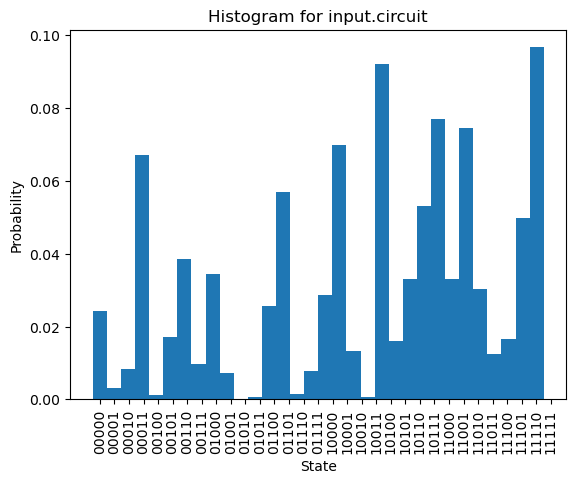

In [12]:
file = "circuits/input.circuit"
state, U, empirical_probs = runSimArray(file, measure=True, ntrials=100000)
nbits = int(np.log2(len(state)))
xlabels = getBinaryList(nbits)
x = np.arange(len(xlabels))
fig, ax = plt.subplots()
plt.hist(x, weights=empirical_probs, bins=len(xlabels), align="left")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel("State")
ax.set_ylabel("Probability")
ax.set_title("Histogram for input.circuit")
plt.show()

## Simulator Mb

In [13]:
def runSimArrayFast(myInput_lines, ntrials=1000, measure=False, initState=None):

    numberOfWires, myInput = ReadInputString(myInput_lines)

    if "MEASURE" in myInput[-1]:
        myInput = myInput[:-1]
        measure = True

    inputState = np.zeros(2**numberOfWires)
    inputState[0] = 1.0  # start in the |0> state as default

    if "INITSTATE" in myInput[0]:

        inputState = myInput[0][-1]
        inputState = readState(inputState)

        if initState != None:

            print(
                'Initial state in input string or file. Ignoring "initState" argument'
            )

    elif initState != None:

        inputState = readState(initState)

    global_state = inputState
    for gate in myInput:

        if gate[0] == "H":
            wire = int(gate[-1])
            global_state = HadamardArray(wire, numberOfWires) @ global_state

        elif gate[0] == "P":
            wire = int(gate[1])
            theta = float(gate[2])
            global_state = PhaseArray(wire, theta, numberOfWires) @ global_state

        elif gate[0] == "CNOT":
            control = int(gate[1])
            notWire = int(gate[2])
            global_state = CNOTArray(control, notWire, numberOfWires) @ global_state

    if measure:
        empircal_probs = measureState(global_state, ntrials)
        return global_state, empircal_probs

    return global_state

## Testing Mb

In [14]:
# Test string input
state = runSimArrayFast(
    """
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
"""
)
print("input string:")
PrettyPrintBinary(VecToDirac(state))
testProb(state)
print()

# Test example.circuit
file = "circuits/example.circuit"
stateMb = runSimArrayFast(file)
print("example.circuit:")
PrettyPrintBinary(AddDuplicates(VecToDirac(stateMb)))
testProb(state)
print()

# Test random.circuit
file = "circuits/rand.circuit"
state = runSimArrayFast(file)
print("random.circuit:")
PrettyPrintBinary(AddDuplicates(VecToDirac(state)))
testProb(state)

input string:
(0.9777+0.1478j)|000> + (0.0223-0.1478j)|101>

example.circuit:
(0.5+0j)|0000> + (0.5+0j)|0011> + (0.4502+0.2175j)|1100> + 
(0.4502+0.2175j)|1111>

random.circuit:
(0.1457+0.1135j)|00000> + (0.0431-0.1218j)|00001> + (-0.0002+0.0801j)|00010> + 
(0.0504-0.0073j)|00011> + (0.0723-0.0226j)|00100> + (-0.0344-0.0422j)|00101> + (0.0539+0.009j)|00110> + 
(0.0018-0.0268j)|00111> + (0.1346-0.1256j)|01000> + (-0.1041-0.0676j)|01001> + (0.0107+0.0709j)|01010> + 
(0.0315-0.0354j)|01011> + (0.0079+0.2979j)|01100> + (0.1961-0.0584j)|01101> + (-0.1131-0.0228j)|01110> + 
(0.0257+0.0756j)|01111> + (0.0015-0.0365j)|10000> + (-0.0127+0.0055j)|10001> + (-0.0821+0.0155j)|10010> + 
(0.016+0.0226j)|10011> + (-0.1717+0.3669j)|10100> + (0.2775+0.0423j)|10101> + (-0.1469-0.0436j)|10110> + 
(0.0074+0.1079j)|10111> + (-0.4427-0.0892j)|11000> + (0.0343+0.318j)|11001> + (-0.0548-0.2147j)|11010> + 
(-0.121+0.0654j)|11011> + (-0.1814-0.078j)|11100> + (-0.0059+0.127j)|11101> + (-0.0578+0.0101j)|11110> + 


In [15]:
print("example.circuit:\n")
print("simulator Ma:")
PrettyPrintBinary(AddDuplicates(VecToDirac(stateMa)))

print("\nsimulator Mb:")
PrettyPrintBinary(AddDuplicates(VecToDirac(stateMb)))

example.circuit:

simulator Ma:
(0.5+0j)|0000> + (0.5+0j)|0011> + (0.4502+0.2175j)|1100> + 
(0.4502+0.2175j)|1111>

simulator Mb:
(0.5+0j)|0000> + (0.5+0j)|0011> + (0.4502+0.2175j)|1100> + 
(0.4502+0.2175j)|1111>


## Complexity

In [16]:
def sortfiles(file):

    return int(file[4:].split(".")[0])


nwires = [i for i in range(2, 14, 2)] + [20]
sTime = []
maTime = []
mbTime = []


for nbits in nwires:

    randCircuit = generateRandomCircuit(nbits=nbits, depth=5)

    # run sim s
    s = time.time()
    x = runSim(randCircuit)
    e = time.time()
    sTime.append(e - s)
    del x

    if nbits <= 12:

        # run sim ma
        s = time.time()
        x = runSimArray(randCircuit)
        e = time.time()
        maTime.append(e - s)
        del x

        # run sim mb
        s = time.time()
        x = runSimArrayFast(randCircuit)
        e = time.time()
        mbTime.append(e - s)

        del x

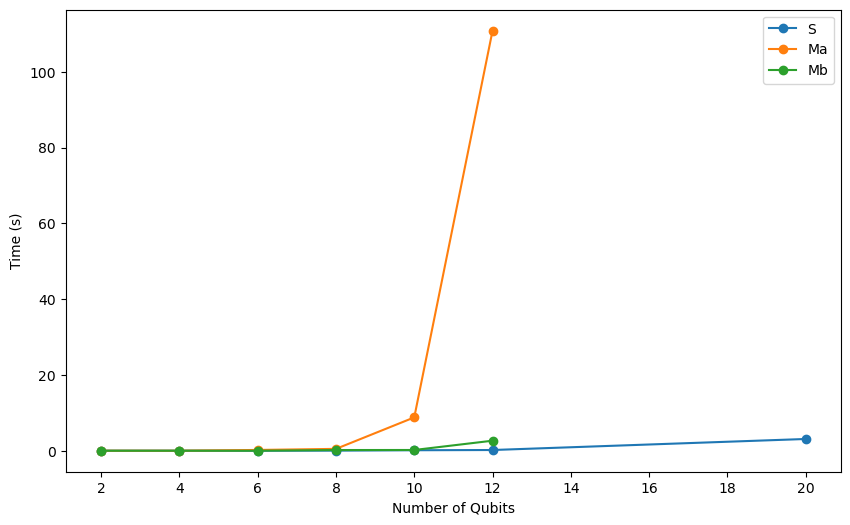

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(nwires, sTime, label="S", marker="o")
ax.plot(nwires[:-1], maTime, label="Ma", marker="o")
ax.plot(nwires[:-1], mbTime, label="Mb", marker="o")
ax.set_xlabel("Number of Qubits")
ax.set_ylabel("Time (s)")
ax.legend()
ax.set_xticks([i for i in range(2, 22, 2)])
plt.show()

## Testing Measure

In [18]:
# sim s theoretical prob vs empirical prob
state, empirical = runSim("circuits/measure.circuit")
theoretical = np.abs(DiracToVec(state)) ** 2

print("Mean difference between theoretical and empirical probabilities for sim s:")
print("\n\t", np.mean(theoretical - empirical))

Mean difference between theoretical and empirical probabilities for sim s:

	 -1.3114441715748881e-16


In [19]:
# sim ma theoretical prob vs empirical prob
state, U, empirical = runSimArray("circuits/measure.circuit")
theoretical = np.abs(state) ** 2

print("Mean difference between theoretical and empirical probabilities for sim ma:")
print("\n\t", np.mean(theoretical - empirical))

Mean difference between theoretical and empirical probabilities for sim ma:

	 -1.6547635657560011e-16


In [20]:
# sim mb theoretical prob
state, empirical = runSimArrayFast("circuits/measure.circuit")
theoretical = np.abs(state) ** 2

print("Mean difference between theoretical and empirical probabilities for sim mb:")
print("\n\t", np.mean(theoretical - empirical))

Mean difference between theoretical and empirical probabilities for sim mb:

	 -1.4674676404591303e-16


## Testing Input

In [21]:
# Test sim S with file instantiation

state = runSim(myInput_lines="circuits/input.circuit")
PrettyPrintBinary(state)

print()

# Test sim S with dirac instantiation |00001>
state = runSim("circuits/inputDirac.circuit", initState="|00001>")
PrettyPrintBinary(state)

(0.1541-0.039j)|00000> + (0.049-0.03j)|00001> + (-0.0213+0.0877j)|00010> + 
(-0.1116-0.2333j)|00011> + (-0.0339-0.0097j)|00100> + (-0.0167-0.1303j)|00101> + 
(-0.1959+0.0099j)|00110> + (-0.098+0.0135j)|00111> + (-0.1808+0.0144j)|01000> + (0.0538-0.0686j)|01001> + 
(0.001-0.0035j)|01010> + (-0.0215+0.0174j)|01011> + (-0.0072+0.1596j)|01100> + 
(-0.2231+0.0746j)|01101> + (-0.0379+0.0059j)|01110> + (0.0739-0.0507j)|01111> + (-0.148+0.0875j)|10000> + 
(-0.0633+0.2566j)|10001> + (0.1169+0.0138j)|10010> + (-0.0267-0.0041j)|10011> + (0.2192-0.213j)|10100> + 
(-0.0489-0.1164j)|10101> + (-0.1479-0.1048j)|10110> + (0.2232+0.0508j)|10111> + (-0.1396-0.2372j)|11000> + 
(0.1848-0.0051j)|11001> + (-0.2632-0.0656j)|11010> + (0.1752-0.0201j)|11011> + (0.1122+0.0012j)|11100> + 
(0.0242-0.1245j)|11101> + (-0.2083+0.077j)|11110> + (0.0548+0.3061j)|11111>

(-0.092+0.0788j)|00000> + (-0.1578-0.0924j)|00001> + (-0.0576+0.0022j)|00010> + 
(-0.0154-0.08j)|00011> + (0.0004+0.0497j)|00100> + (-0.0685+0.03j)|001

In [22]:
# Test sim ma with file instantiation
state, U = runSimArray("circuits/input.circuit")
PrettyPrintBinary(VecToDirac(state))

print()

# Test sim mb with dirac instantiation |00001>
state = runSimArrayFast("circuits/inputDirac.circuit", initState="|00001>")
PrettyPrintBinary(VecToDirac(state))

(0.1541-0.039j)|00000> + (0.049-0.03j)|00001> + (-0.0213+0.0877j)|00010> + 
(-0.1116-0.2333j)|00011> + (-0.0339-0.0097j)|00100> + (-0.0167-0.1303j)|00101> + 
(-0.1959+0.0099j)|00110> + (-0.098+0.0135j)|00111> + (-0.1808+0.0144j)|01000> + (0.0538-0.0686j)|01001> + 
(0.001-0.0035j)|01010> + (-0.0215+0.0174j)|01011> + (-0.0072+0.1596j)|01100> + 
(-0.2231+0.0746j)|01101> + (-0.0379+0.0059j)|01110> + (0.0739-0.0507j)|01111> + (-0.148+0.0875j)|10000> + 
(-0.0633+0.2566j)|10001> + (0.1169+0.0138j)|10010> + (-0.0267-0.0041j)|10011> + (0.2192-0.213j)|10100> + 
(-0.0489-0.1164j)|10101> + (-0.1479-0.1048j)|10110> + (0.2232+0.0508j)|10111> + (-0.1396-0.2372j)|11000> + 
(0.1848-0.0051j)|11001> + (-0.2632-0.0656j)|11010> + (0.1752-0.0201j)|11011> + (0.1122+0.0012j)|11100> + 
(0.0242-0.1245j)|11101> + (-0.2083+0.077j)|11110> + (0.0548+0.3061j)|11111>

(-0.092+0.0788j)|00000> + (-0.1578-0.0924j)|00001> + (-0.0576+0.0022j)|00010> + 
(-0.0154-0.08j)|00011> + (0.0004+0.0497j)|00100> + (-0.0685+0.03j)|001

In [23]:
# Test sim mb with file instantiation
state = runSimArrayFast("circuits/input.circuit")
PrettyPrintBinary(VecToDirac(state))

print()

# Test sim S with file instantiation |00001>
state = runSimArrayFast("circuits/inputDirac.circuit")
PrettyPrintBinary(VecToDirac(state))

(0.1541-0.039j)|00000> + (0.049-0.03j)|00001> + (-0.0213+0.0877j)|00010> + 
(-0.1116-0.2333j)|00011> + (-0.0339-0.0097j)|00100> + (-0.0167-0.1303j)|00101> + 
(-0.1959+0.0099j)|00110> + (-0.098+0.0135j)|00111> + (-0.1808+0.0144j)|01000> + (0.0538-0.0686j)|01001> + 
(0.001-0.0035j)|01010> + (-0.0215+0.0174j)|01011> + (-0.0072+0.1596j)|01100> + 
(-0.2231+0.0746j)|01101> + (-0.0379+0.0059j)|01110> + (0.0739-0.0507j)|01111> + (-0.148+0.0875j)|10000> + 
(-0.0633+0.2566j)|10001> + (0.1169+0.0138j)|10010> + (-0.0267-0.0041j)|10011> + (0.2192-0.213j)|10100> + 
(-0.0489-0.1164j)|10101> + (-0.1479-0.1048j)|10110> + (0.2232+0.0508j)|10111> + (-0.1396-0.2372j)|11000> + 
(0.1848-0.0051j)|11001> + (-0.2632-0.0656j)|11010> + (0.1752-0.0201j)|11011> + (0.1122+0.0012j)|11100> + 
(0.0242-0.1245j)|11101> + (-0.2083+0.077j)|11110> + (0.0548+0.3061j)|11111>

(0.1457+0.1135j)|00000> + (0.0431-0.1218j)|00001> + (-0.0002+0.0801j)|00010> + 
(0.0504-0.0073j)|00011> + (0.0723-0.0226j)|00100> + (-0.0344-0.0422j)|0

## Non-atomic Gates

In [24]:
def notGate(i):
    """First hadamard creates a superposition of |0> and |1>, then the phase gate flips the sign on |1>. The second hadamard converts back to the computational basis:

    H i
    P i pi
    H i
    """
    H1 = f"H {i} \n"
    rotate = f"P {i} {np.pi}\n"
    H2 = f"H {i} \n"

    return H1 + rotate + H2


def Rz(i, theta):
    """The first phase gate rotates |1> by theta/2, the not gate changes the |0> to |1>, the second phase gate rotates the new |1> by -theta/2, and the second not gate changes the |1> back to |0>:

    P i theta/2

    NOT i

    P i -theta/2

    NOT i

    Notes
    -----
    We must do it this way because only relative changes in phase between |0> and |1> are physically meaningful. If we only rotated |1> by theta, we would not be able to distinguish between the state |0> and the state e^(i*theta)|0> = |0>.
    """
    P1 = f"P {i} {theta / 2}\n"
    not1 = notGate(i)
    P2 = f"P {i} {-theta / 2}\n"
    not2 = notGate(i)

    return P1 + not1 + P2 + not2


def CRz(control, notWire, theta):
    """P notWire theta/2
    CNOT control notWire
    P notWire -theta/2
    CNOT control notWire
    """

    P1 = f"P {notWire} {theta / 2}\n"
    CNOT = f"CNOT {control} {notWire}\n"
    P2 = f"P {notWire} {-theta / 2}\n"
    CNOT2 = f"CNOT {control} {notWire}\n"

    return P1 + CNOT + P2 + CNOT2


def CRz(control, notWire, theta):
    """ """
    Rz1 = Rz(notWire, theta / 2)
    CNOT1 = f"CNOT {control} {notWire}\n"
    Rz2 = Rz(notWire, -theta / 2)
    CNOT2 = f"CNOT {control} {notWire}\n"

    return Rz1 + CNOT1 + Rz2 + CNOT2


def CP(control, notWire, theta):
    """
    P control theta/2
    CRz control notWire theta
    """

    P1 = f"P {control} {theta / 2}\n"
    CRz1 = CRz(control, notWire, theta)

    return P1 + CRz1


def CP(control, notWire, theta):
    """ """

    P1 = f"P {control} {theta / 2}\n"
    CNOT1 = f"CNOT {control} {notWire}\n"
    P2 = f"P {notWire} {-theta / 2}\n"
    CNOT2 = f"CNOT {control} {notWire}\n"
    P3 = f"P {notWire} {theta / 2}\n"

    return P1 + CNOT1 + P2 + CNOT2 + P3


def SWAP(n, m):
    """
    CNOT n m
    CNOT m n
    CNOT n m
    """
    CNOT1 = f"CNOT {n} {m}\n"
    CNOT2 = f"CNOT {m} {n}\n"
    CNOT3 = f"CNOT {n} {m}\n"

    return CNOT1 + CNOT2 + CNOT3


def precompile(input):

    numberOfWires, myInput = ReadInputString(input)

    if os.path.isfile(input):

        with open(input + ".compiled", "w") as output:

            output.write(str(numberOfWires) + "\n")

            for line in myInput:

                gate = line

                if "INITSTATE" in line[0]:

                    output.write(line)

                elif gate[0] == "NOT":

                    output.write(notGate(int(gate[1])))

                elif gate[0] == "Rz":

                    output.write(Rz(int(gate[1]), float(gate[2])))

                elif gate[0] == "CRz":

                    output.write(CRz(int(gate[1]), int(gate[2]), float(gate[3])))

                elif gate[0] == "CPHASE":
                    output.write(CP(int(gate[1]), int(gate[2]), float(gate[3])))

                elif gate[0] == "SWAP":
                    output.write(SWAP(int(gate[1]), int(gate[2])))

                else:

                    output.write(" ".join(gate) + "\n")

        return ReadInputString(input + ".compiled")

    # if I don't want to write to a file, return compiled string
    else:

        output = ""
        output += str(numberOfWires) + "\n"

        for line in myInput:

            if line == "":

                continue

            gate = line

            if "INITSTATE" in line[0]:

                output += " ".join(line) + "\n"

            elif gate[0] == "NOT":

                output += notGate(int(gate[1]))

            elif gate[0] == "Rz":

                output += Rz(int(gate[1]), float(gate[2]))

            elif gate[0] == "CRz":

                output += CRz(int(gate[1]), int(gate[2]), float(gate[3]))

            elif gate[0] == "CPHASE":
                output += CP(int(gate[1]), int(gate[2]), float(gate[3]))

            elif gate[0] == "SWAP":
                output += SWAP(int(gate[1]), int(gate[2]))

            else:

                output += " ".join(gate) + "\n"

        return output

## Testing Non-atomic Gates and Precompiler

In [25]:
circ = """
9
H 0
CPHASE 0 5 0.3
P 1 0.3
CNOT 4 7
SWAP 2 8
"""
circ = precompile(circ)
PrettyPrintBinary(runSim(circ))

(0.7071+0j)|000000000> + (0.7071+0j)|100000000>


## Phase Estimation

In [26]:
def phaseEst(circ, ntrials=1000):
    """Perform phase estimation on a circuit at a single phi

    Parameters
    ----------
    circ : str
        The circuit to perform phase estimation on
    ntrials : int
        The number of measurement trials

    Returns
    -------
    float
        The estimated phase theta_j

    np.ndarray
        The probabilities of measuring each state
    """

    circ = precompile(circ)
    _, probs0 = runSim(circ, ntrials=ntrials, measure=True)
    argmax = np.argmax(probs0)  # get the index of the max probability
    probs = np.zeros(len(probs0))
    probs[argmax] = 1.0
    state = AddDuplicates(VecToDirac(probs))
    binary = state[0][1][:-1]  # extract top wire states
    nqubits = len(binary)
    theta = int(binary, 2) / 2**nqubits

    return theta, probs0


def topWireDecimalStates(probs, nbottom):
    """Extract the decimal states of the top wires

    Parameters
    ----------
    probs : np.ndarray
        The probabilities of measuring each binary state
    ntop : int
        The number of top wires

    Returns
    -------
    np.ndarray
        The decimal states of the top wires
    """

    binaryStates = StateToArray(AddDuplicates(VecToDirac(probs)))[
        :, 1
    ]  # extract the binary states
    binaryStates = [
        state[:-nbottom] for state in binaryStates
    ]  # remove the bottom wire bits
    nbits = len(binaryStates[0])
    decimalStates = BinaryToDecimal(binaryStates) / (2**nbits)

    return decimalStates


def thetaHist(decimalStates, probs, phi=None):
    """Plot a histogram of the phase estimates in decimal

    Parameters
    ----------
    decimalStates : np.ndarray
        The decimal states of the top wires
    probs : np.ndarray
        The probabilities of measuring each binary state
    phi : float
        The true phase to plot

    Returns
    -------
    None
    """

    nbits = int(np.log2(len(decimalStates)))
    binWidth = 1 / (2**nbits)

    plt.bar(decimalStates, probs[probs != 0], width=binWidth)
    plt.xlabel(r"$\theta_{j}$", fontsize=16)
    plt.ylabel("Probability", fontsize=16)
    if phi != None:
        plt.vlines(phi / np.pi / 2, 0, np.max(probs), color="black", linestyle="--")

    plt.show()


def plotTheta(phis, thetas):
    """Plot the phase estimates vs the true phase

    Parameters
    ----------
    phis : np.ndarray
        The true phases
    thetas : np.ndarray
        The estimated phases

    Returns
    -------
    None
    """

    plt.plot(phis / (2 * np.pi), thetas)
    plt.xlabel(r"$\frac{\phi}{2\pi}$", fontsize=16)
    plt.ylabel(r"$\theta_{j}$", fontsize=16)
    plt.show()


def reverse(nbits):
    """Reverse the order of qubits in a circuit using SWAP gates

    Parameters
    ----------
    nbits : int
        The number of qubits

    Returns
    -------
    str
        The circuit string that reverses the order

    """

    output = ""
    for i in range(nbits // 2):

        output += f"SWAP {i} {nbits - 1 - i}\n"

    return output


def QFT(nbits, initState=None):
    """Quantum Fourier Transform

    Parameters
    ----------
    nbits : int
        The number of qubits
    initState : str, file path, dirac string, or list of tuples
        The initial state of the qubits

    Returns
    -------
    str
        The circuit string
    str
        The compiled circuit
    """

    output = ""
    output += str(nbits) + "\n"

    if initState != None:

        output += f"INITSTATE FILE {initState}\n"

    for control in range(nbits - 1, -1, -1):

        output += f"H {control}\n"

        for notWire in range(control - 1, -1, -1):

            theta = np.pi / (2 ** (control - notWire))
            output += f"CPHASE {control} {notWire} {theta}\n"

    output += reverse(nbits)

    return output, precompile(output)


def invQFT(nbits):

    output = f"{nbits}\n"
    # undo the swaps
    output += reverse(nbits)

    for control in range(nbits - 1, -1, -1):
        output += f"H {control}\n"
        for notWire in range(control):

            theta = -np.pi / (2 ** (control - notWire))
            output += f"CPHASE {control} {notWire} {theta}\n"

    compiled = precompile(output)
    compiled = compiled[1:].strip()
    output = output[1:].strip() + "\n"

    return output, compiled


def buildPhaseEstCirc(ntop, nbottom, phase, initState=None):
    """Builds a circuit with ntop wires and nbottom wires to estimate the phase of the bottom qubits.

    Parameters
    ----------
    ntop : int
        The number of wires on top

    nbottom : int
        The number of wires on bottom

    phase : float
        The true phase of the bottom wires to estimate

    initState : file path, dirac string, or list of tuples, optional
        The initial state of the circuit

    """
    n = ntop + nbottom

    output = f"{n}\n"

    if initState != None:

        output += f"INITSTATE FILE {initState}\n"

    else:

        output += f"INITSTATE |{'0' * ntop}{'1' * nbottom}>\n"

    for top in range(ntop):

        output += f"H {top}\n"

    for top in range(ntop):

        theta = phase * 2 ** (ntop - top - 1)
        output += f"CPHASE {top} {ntop} {theta}\n"

    output += invQFT(ntop)[0]

    return output, precompile(output)


def phaseEstSim(phis, ntop, nbottom, ntrials=1000, initState=None):

    if initState == None:

        initState = f'|{"0" * ntop}{"1" * nbottom}>'

    thetas = []
    probs0 = []
    for phi in phis:

        circ, compiled = buildPhaseEstCirc(ntop, nbottom, phi, initState=initState)
        theta, prob0 = phaseEst(circ, ntrials=ntrials)
        thetas.append(theta)
        probs0.append(prob0)

    if len(probs0) == 1:

        return thetas[0], probs0[0]

    return thetas, probs0

## 1 top 1 bottom wire phase estimate

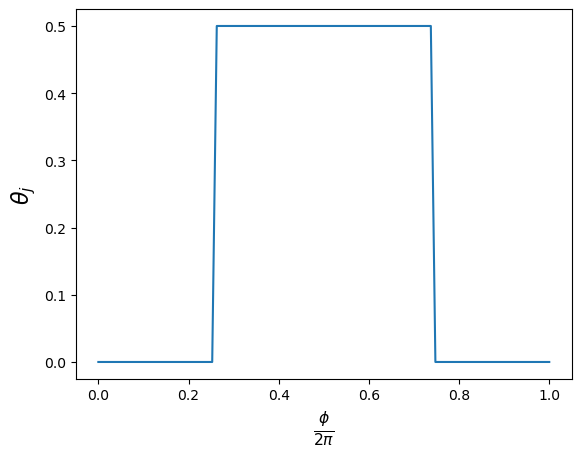

In [27]:
phis = np.linspace(0, 2 * np.pi, 100)
ntop = 1
nbottom = 1
thetas, probs = phaseEstSim(phis, ntop, nbottom, ntrials=1000)
plotTheta(phis, thetas)

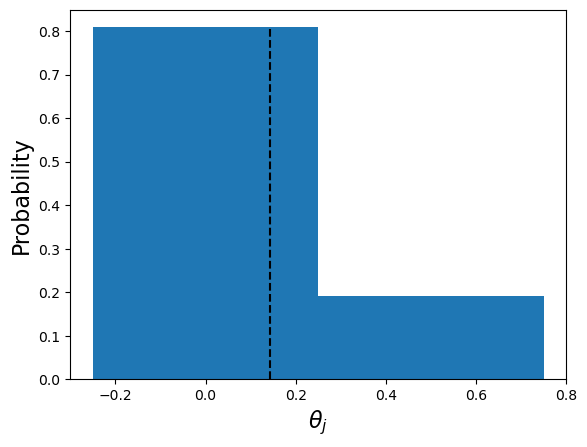

In [28]:
phi = 0.9
theta, probs = phaseEstSim([phi], ntop, nbottom, ntrials=10000)
decimalStates = topWireDecimalStates(probs, nbottom)
thetaHist(decimalStates, probs, phi)

## 2 top 1 bottom wire phase estimate

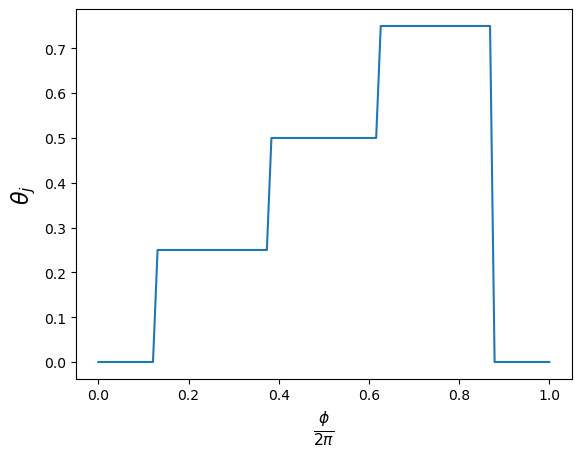

In [29]:
ntop = 2
nbottom = 1
phis = np.linspace(0, 2 * np.pi, 100)
thetas, probs = phaseEstSim(phis, ntop, nbottom, ntrials=1000)
plotTheta(phis, thetas)

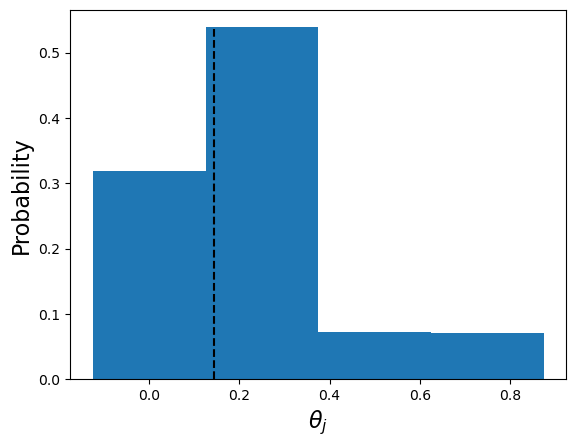

In [30]:
phi = 0.9
theta, probs = phaseEstSim([phi], ntop, nbottom, ntrials=10000)
decimalStates = topWireDecimalStates(probs, nbottom)
thetaHist(decimalStates, probs, phi)

## QFT Verification

## 6 top, 3 bottom phase estimate

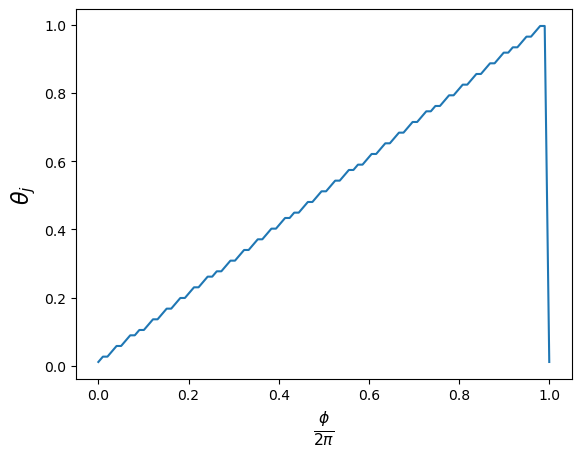

In [31]:
ntop = 6
nbottom = 3
phis = np.linspace(0, 2 * np.pi, 100)
thetas, probs = phaseEstSim(phis, ntop, nbottom, ntrials=1000)
plotTheta(phis, thetas)

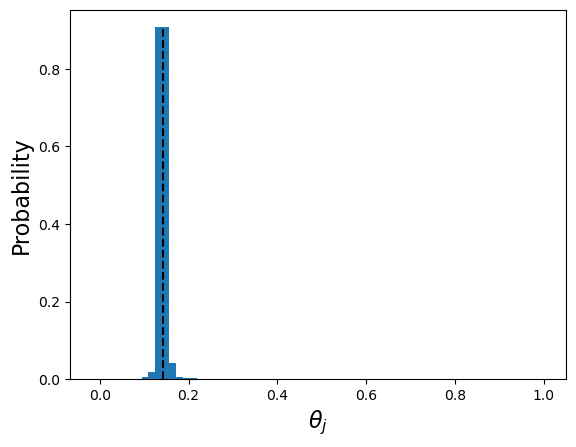

In [32]:
phi = 0.9
theta, probs = phaseEstSim([phi], ntop, nbottom, ntrials=10000)
decimalStates = topWireDecimalStates(probs, nbottom)
thetaHist(decimalStates, probs, phi)

## Different eigenstate

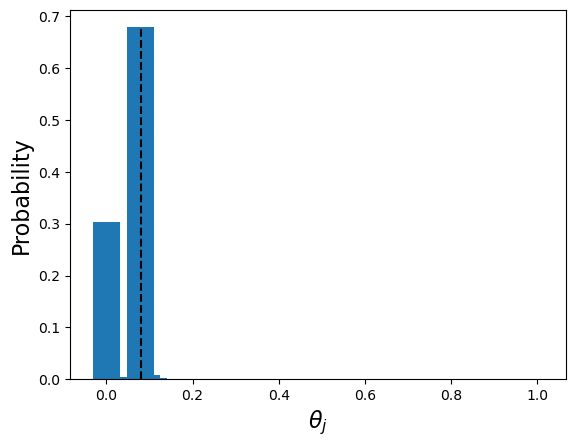

In [33]:
initState = [(np.sqrt(0.3), ("000000000")), (np.sqrt(0.7), "000000100")]
phi = 0.5
ntop = 6
nbottom = 3
theta, probs = phaseEstSim([phi], ntop, nbottom, ntrials=10000, initState=initState)
decimalStates = topWireDecimalStates(probs, nbottom)
thetaHist(decimalStates, probs, phi)

## Testing QFT

In [34]:
ntop = 6
nbottom = 3
phi = 0.5
circ, compiled = buildPhaseEstCirc(6, 3, phi)
print(circ)

9
INITSTATE |000000111>
H 0
H 1
H 2
H 3
H 4
H 5
CPHASE 0 6 16.0
CPHASE 1 6 8.0
CPHASE 2 6 4.0
CPHASE 3 6 2.0
CPHASE 4 6 1.0
CPHASE 5 6 0.5
SWAP 0 5
SWAP 1 4
SWAP 2 3
H 5
CPHASE 5 0 -0.09817477042468103
CPHASE 5 1 -0.19634954084936207
CPHASE 5 2 -0.39269908169872414
CPHASE 5 3 -0.7853981633974483
CPHASE 5 4 -1.5707963267948966
H 4
CPHASE 4 0 -0.19634954084936207
CPHASE 4 1 -0.39269908169872414
CPHASE 4 2 -0.7853981633974483
CPHASE 4 3 -1.5707963267948966
H 3
CPHASE 3 0 -0.39269908169872414
CPHASE 3 1 -0.7853981633974483
CPHASE 3 2 -1.5707963267948966
H 2
CPHASE 2 0 -0.7853981633974483
CPHASE 2 1 -1.5707963267948966
H 1
CPHASE 1 0 -1.5707963267948966
H 0


### 3 bit QFT vs qiskit

In [35]:
nbits = 3
qft3, compiled = QFT(nbits, initState="|000>")
print(qft3)

states = runSim(compiled)
PrettyPrintBinary(states)

3
INITSTATE FILE |000>
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
SWAP 0 2

(0.3536+0j)|000> + (0.3536+0j)|001> + (0.3536-0j)|010> + (0.3536-0j)|011> + 
(0.3536-0j)|100> + (0.3536-0j)|101> + (0.3536-0j)|110> + (0.3536-0j)|111>


(0.3536+0j)|000> + (0.3536+0j)|001> + (0.3536+0j)|010> + (0.3536+0j)|011> + 
(0.3536+0j)|100> + (0.3536+0j)|101> + (0.3536+0j)|110> + (0.3536+0j)|111>


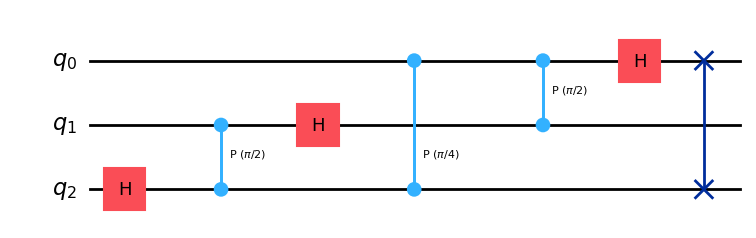

In [36]:
from qiskit.circuit.library import QFT as qisQFT
from qiskit_aer import Aer
from qiskit import transpile

sim = Aer.get_backend("unitary_simulator")
qc = qisQFT(3)
qc = transpile(qc, sim)
unitary = sim.run(qc).result().get_unitary()
unitary = np.asarray(unitary).round(4)
input = np.array([1, 0, 0, 0, 0, 0, 0, 0])
output = unitary.T @ input
PrettyPrintBinary(VecToDirac(output))
qc.draw("mpl")

## 5 bit QFT vs qiskit

In [37]:
qft5, compiled = QFT(5, "myInputState.txt")
print(qft5)
states = runSim(compiled)
PrettyPrintBinary(states)

5
INITSTATE FILE myInputState.txt
H 4
CPHASE 4 3 1.5707963267948966
CPHASE 4 2 0.7853981633974483
CPHASE 4 1 0.39269908169872414
CPHASE 4 0 0.19634954084936207
H 3
CPHASE 3 2 1.5707963267948966
CPHASE 3 1 0.7853981633974483
CPHASE 3 0 0.39269908169872414
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
SWAP 0 4
SWAP 1 3

(-0.0403-0.2209j)|00000> + (0.0537-0.3213j)|00001> + (0.1757+0.0802j)|00010> + 
(-0.1096+0.0022j)|00011> + (0.0191+0.0706j)|00100> + (-0.0928-0.1661j)|00101> + (-0.0849-0.0967j)|00110> + 
(0.1625-0.0853j)|00111> + (0.2493+0.0642j)|01000> + (-0.1524-0.1436j)|01001> + (-0.0003+0.0288j)|01010> + 
(-0.0839+0.1516j)|01011> + (0.0323-0.1069j)|01100> + (0.0165-0.0136j)|01101> + (0.0083-0.1441j)|01110> + 
(0.0943-0.0559j)|01111> + (0.0392+0.0239j)|10000> + (0.084-0.0938j)|10001> + (-0.0791+0.0339j)|10010> + 
(-0.1205-0.0218j)|10011> + (-0.033+0.1764j)|10100> + (-0.0114+0.1021j)|10101> + (-0.1229-0.2535j)|10110> + 
(0.2661-0.

(-0.0403-0.2209j)|00000> + (0.1411+0.1665j)|00001> + (0.1848+0.0639j)|00010> + 
(0.0003-0.0222j)|00011> + (0.1567-0.0846j)|00100> + (0.2119-0.1355j)|00101> + (0.0244+0.0073j)|00110> + 
(0.1228-0.2049j)|00111> + (0.2166+0.0201j)|01000> + (0.1072+0.0013j)|01001> + (-0.2352-0.001j)|01010> + 
(-0.077-0.1674j)|01011> + (-0.0014+0.1086j)|01100> + (-0.0452-0.1133j)|01101> + 
(-0.1991-0.1132j)|01110> + (-0.1595+0.1467j)|01111> + (-0.0337+0.0794j)|10000> + (0.028-0.0007j)|10001> + 
(-0.0288-0.0853j)|10010> + (-0.2534-0.2309j)|10011> + (0.2441+0.0389j)|10100> + (-0.125-0.0073j)|10101> + 
(-0.1493-0.0427j)|10110> + (0.1768-0.0506j)|10111> + (-0.1181+0.0162j)|11000> + (-0.1053+0.0386j)|11001> + 
(-0.0293+0.0125j)|11010> + (-0.2141+0.0843j)|11011> + (0.1258-0.0245j)|11100> + (-0.077-0.1228j)|11101> + 
(0.0763-0.1187j)|11110> + (-0.1723+0.002j)|11111>


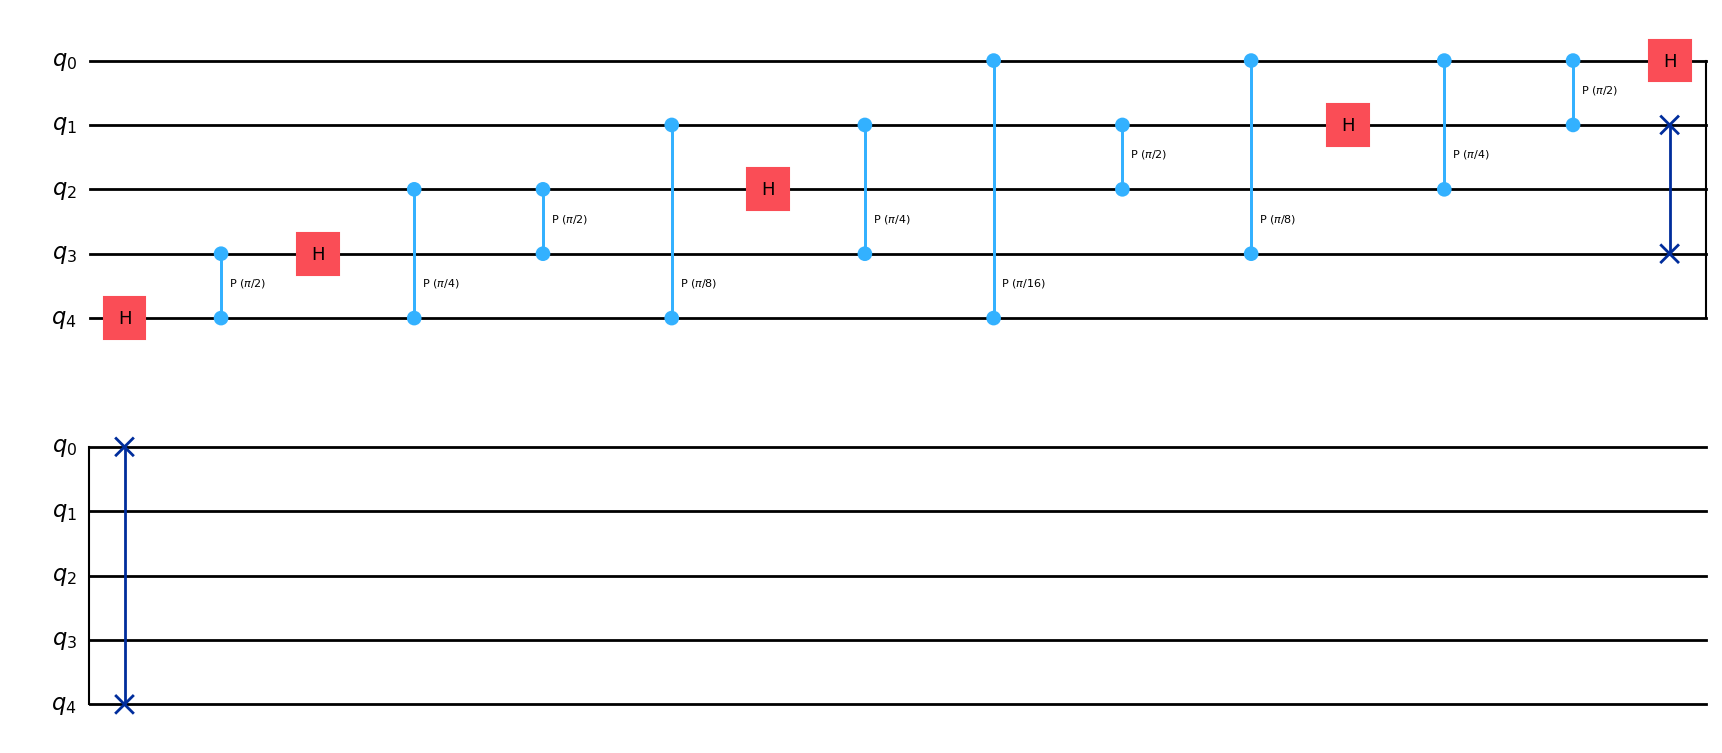

In [38]:
sim = Aer.get_backend("unitary_simulator")
qc = qisQFT(5, do_swaps=True, inverse=False)
qc = transpile(qc, sim)
unitary = sim.run(qc).result().get_unitary()
unitary = np.asarray(unitary).round(20)
input = readState("myInputState.txt")
output = unitary @ input
PrettyPrintBinary(VecToDirac(output))
qc.draw("mpl")

In [39]:
print(unitary.shape)
print(unitary.round(2))

(32, 32)
[[ 0.18+0.j    0.18-0.j    0.18-0.j   ...  0.18-0.j    0.18-0.j
   0.18-0.j  ]
 [ 0.18+0.j    0.17+0.03j  0.16+0.07j ...  0.15-0.1j   0.16-0.07j
   0.17-0.03j]
 [ 0.18+0.j    0.16+0.07j  0.13+0.12j ...  0.07-0.16j  0.12-0.13j
   0.16-0.07j]
 ...
 [ 0.18+0.j    0.15-0.1j   0.07-0.16j ... -0.03+0.17j  0.07+0.16j
   0.15+0.1j ]
 [ 0.18+0.j    0.16-0.07j  0.12-0.13j ...  0.07+0.16j  0.13+0.12j
   0.16+0.07j]
 [ 0.18+0.j    0.17-0.03j  0.16-0.07j ...  0.15+0.1j   0.16+0.07j
   0.17+0.03j]]


In [40]:
from qiskit.circuit.library import QFT as qisQFT
from qiskit_aer import Aer
from qiskit import transpile

sim = Aer.get_backend("unitary_simulator")
qc = qisQFT(num_qubits=2, approximation_degree=0)
qc = transpile(qc, sim)
unitary = sim.run(qc).result().get_unitary()
unitary = np.asarray(unitary).round(4)
input = DiracToVec([(1, "01")])
output = unitary.T @ input
PrettyPrintBinary(VecToDirac(output))
qc.draw("mpl")
print()
# print(unitary)

(0.5+0j)|00> + 0.5j|01> + (-0.5+0j)|10> + -0.5j|11>


In [41]:
nbits = 3
qft3, compiled = QFT(nbits, initState="|101>")
print(qft3)

states = runSim(compiled)
PrettyPrintBinary(states)
print()
print(compiled)

3
INITSTATE FILE |101>
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
SWAP 0 2

(0.3536+0j)|000> + (-0.3536-0j)|001> + 0.3536j|010> + (-0-0.3536j)|011> + 
(-0.25-0.25j)|100> + (0.25+0.25j)|101> + (0.25-0.25j)|110> + (-0.25+0.25j)|111>

3
INITSTATE FILE |101>
H 2
P 2 0.7853981633974483
CNOT 2 1
P 1 -0.7853981633974483
CNOT 2 1
P 1 0.7853981633974483
P 2 0.39269908169872414
CNOT 2 0
P 0 -0.39269908169872414
CNOT 2 0
P 0 0.39269908169872414
H 1
P 1 0.7853981633974483
CNOT 1 0
P 0 -0.7853981633974483
CNOT 1 0
P 0 0.7853981633974483
H 0
CNOT 0 2
CNOT 2 0
CNOT 0 2


In [42]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UGate, PhaseGate, HGate, CPhaseGate, CRZGate, RZGate
from qiskit.transpiler.passes import Decompose

In [43]:
output, U = runSimArray(compiled)
print(U.round(4))

[[ 0.3536+0.j      0.3536+0.j      0.3536+0.j      0.3536+0.j
   0.3536+0.j      0.3536+0.j      0.3536+0.j      0.3536+0.j    ]
 [ 0.3536+0.j      0.3536+0.j      0.3536+0.j      0.3536+0.j
  -0.3536-0.j     -0.3536-0.j     -0.3536-0.j     -0.3536-0.j    ]
 [ 0.3536+0.j      0.3536+0.j     -0.3536-0.j     -0.3536-0.j
   0.    +0.3536j  0.    +0.3536j -0.    -0.3536j -0.    -0.3536j]
 [ 0.3536+0.j      0.3536+0.j     -0.3536-0.j     -0.3536-0.j
  -0.    -0.3536j -0.    -0.3536j  0.    +0.3536j  0.    +0.3536j]
 [ 0.3536-0.j     -0.3536+0.j      0.    +0.3536j -0.    -0.3536j
   0.25  +0.25j   -0.25  -0.25j   -0.25  +0.25j    0.25  -0.25j  ]
 [ 0.3536-0.j     -0.3536+0.j      0.    +0.3536j -0.    -0.3536j
  -0.25  -0.25j    0.25  +0.25j    0.25  -0.25j   -0.25  +0.25j  ]
 [ 0.3536-0.j     -0.3536+0.j     -0.    -0.3536j  0.    +0.3536j
  -0.25  +0.25j    0.25  -0.25j    0.25  +0.25j   -0.25  -0.25j  ]
 [ 0.3536-0.j     -0.3536+0.j     -0.    -0.3536j  0.    +0.3536j
   0.25  -0.25j   -

     ┌──────┐
q_0: ┤0     ├
     │  QFT │
q_1: ┤1     ├
     └──────┘


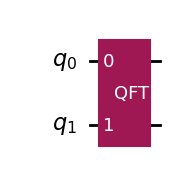

In [44]:
qc = qisQFT(num_qubits=2, approximation_degree=0)
qc = qc.decompose("PhaseGate")
print(qc)
qc.draw("mpl")

In [45]:
qc = QuantumCircuit(2)
# qc.h(0)
# print(qc.decompose(reps=4))
qc.crz(np.pi, 1, 0)
print(qc)
print(qc.decompose(CRZGate, reps=2))

     ┌───────┐
q_0: ┤ Rz(π) ├
     └───┬───┘
q_1: ────■────
              
     ┌─────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Rz(π/2) ├┤ X ├┤ Rz(-π/2) ├┤ X ├
     └─────────┘└─┬─┘└──────────┘└─┬─┘
q_1: ─────────────■────────────────■──
                                      


(0.0, 1.0)

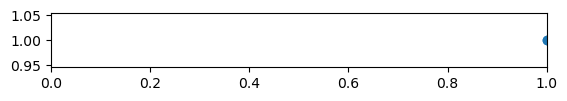

In [46]:
x, y = np.ones(2), np.ones(2)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_aspect("equal")
ax.set_xlim(0, 1)